In [1]:
import gzip
import json
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import string
import numpy as np
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import word2vec
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from livelossplot import PlotLossesKeras

from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# from nltk.stem import PorterStemmer

Using TensorFlow backend.


In [2]:
import gensim
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
import spacy

In [71]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/shz275/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [75]:
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shz275/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [77]:
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/shz275/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Prepare data

In [5]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [6]:
review = list(parse("Gift_Cards.json.gz"))

In [10]:
review[1]

{'overall': 5.0,
 'verified': False,
 'reviewTime': '12 17, 2008',
 'reviewerID': 'A3G8U1G1V082SN',
 'asin': 'B001GXRQW0',
 'style': {'Gift Amount:': ' 50'},
 'reviewerName': 'Tali',
 'reviewText': 'I got this gift card from a friend, and it was the best! The site has so much to choose from... great gift.',
 'summary': 'Gift card with best selection',
 'unixReviewTime': 1229472000}

In [7]:
meta = list(parse("meta_Gift_Cards.json.gz"))

In [59]:
meta[2]

{'category': ['Gift Cards', 'Gift Cards'],
 'tech1': '',
 'description': ['<div class="aplus"> <br>Amazon.com Gift Cards are the perfect way to give them exactly what they\'re hoping for--even if you don\'t know what it is. Amazon.com Gift Cards are redeemable for millions of items storewide, and never expire.<br /><br /> Box of 50 physical Amazon.com Gift Cards. Each card is attached to a folded greeting card and is packed in an individual 5 x 7 inch unsealed envelope. Also available to purchase as <a href="http://www.amazon.com/gp/product/B001H53QDK/ref=g_gc_asin_dp_sgl">individual gift cards</a>.<br/><br/> <a href="http://www.amazon.com/gp/product/B00067L6TQ/ref=g_gc_asin_dp_gclp">Check out our customized E-mail, Print at Home, and Mail gift card options</a>. Need a gift card in a hurry? Buy an Amazon.com Gift Card at <a href="http://www.amazon.com/gp/feature.html?docId=1000465651">a store near you</a>.<br /><br /> Amazon.com Gift Cards are a great way to motivate, reward, and appre

In [37]:
review_user = [i['reviewerID'] for i in review]
review_item = [i['asin'] for i in review]
review_text = [i['reviewText'] if 'reviewText' in i else '' for i in review]
review_rating = [i['overall'] for i in review]

In [31]:
meta_title = [i['title'] for i in meta]
meta_item = [i['asin'] for i in meta]
meta_text = [' '.join(i['description']) if len(i['description'])>0 else '' for i in meta]

In [60]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [68]:
def preprocess(text):
    # remove all html markup
    text=re.sub("(<.*?>)","",text)  
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    # lower text
    text = text.lower()
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    return(text)

In [62]:
ratings  = pd.DataFrame({'reviewerID': review_user, 'item_id':review_item,\
                                      'text':review_text,'rating':review_rating})
ratings

,reviewerID,item_id,text,rating
0,APV13CM0919JD,B001GXRQW0,"Amazon,\nI am shopping for Amazon.com gift car...",1.0
1,A3G8U1G1V082SN,B001GXRQW0,"I got this gift card from a friend, and it was...",5.0
2,A11T2Q0EVTUWP,B001GXRQW0,aren't we going to save trees?! :) People who ...,5.0
3,A9YKGBH3SV22C,B001GXRQW0,You can always get someone something from Amaz...,5.0
4,A34WZIHVF3OKOL,B001GXRQW0,Why take 50 dollars of good money with no limi...,1.0
5,A221J8EC5HNPY6,B001GXRQW0,Gift Cards are the truly personal gift. My on...,3.0
6,A204VFHD6JWASO,B001GXRQW0,"I am a dedicated Amazon.com shopper, and, am a...",1.0
7,A3QN3GMNS7NBIQ,B001GXRQW0,"Bought three $50 gift cards as gifts, received...",1.0
8,A1BXZIDZOMBAV2,B001GXRQW0,At this time of year Amazon gift cards are tur...,5.0
9,AJ7D8N3Z1Q7MK,B001GXRQW0,I bought 8 gift cards to give out as presents....,1.0


In [80]:
ratings["review_clean"] = ratings["text"].apply(lambda x: preprocess(x))
ratings

,reviewerID,item_id,text,rating,review_clean
0,APV13CM0919JD,B001GXRQW0,"Amazon,\nI am shopping for Amazon.com gift car...",1.0,amazon shopping amazon com gift card christmas...
1,A3G8U1G1V082SN,B001GXRQW0,"I got this gift card from a friend, and it was...",5.0,get gift card friend best site much choose gre...
2,A11T2Q0EVTUWP,B001GXRQW0,aren't we going to save trees?! :) People who ...,5.0,go save tree people complain paper gift card s...
3,A9YKGBH3SV22C,B001GXRQW0,You can always get someone something from Amaz...,5.0,always get someone something amazon safety net...
4,A34WZIHVF3OKOL,B001GXRQW0,Why take 50 dollars of good money with no limi...,1.0,take dollar good money limitation turn amazon ...
5,A221J8EC5HNPY6,B001GXRQW0,Gift Cards are the truly personal gift. My on...,3.0,gift card truly personal gift problem receive ...
6,A204VFHD6JWASO,B001GXRQW0,"I am a dedicated Amazon.com shopper, and, am a...",1.0,dedicate amazon com shopper almost always happ...
7,A3QN3GMNS7NBIQ,B001GXRQW0,"Bought three $50 gift cards as gifts, received...",1.0,buy three gift card gift receive mail one week...
8,A1BXZIDZOMBAV2,B001GXRQW0,At this time of year Amazon gift cards are tur...,5.0,time year amazon gift card turn best gift give...
9,AJ7D8N3Z1Q7MK,B001GXRQW0,I bought 8 gift cards to give out as presents....,1.0,buy gift card give present totally surprised c...


In [81]:
ratings.drop('text', axis=1, inplace=True)

In [85]:
items  = pd.DataFrame({'item_id':meta_item, 'title':meta_title, 'description':meta_text})
items

,item_id,title,description
0,B001BKEWF2,Serendipity 3 $100.00 Gift Card,Gift card for the purchase of goods or service...
1,B001GXRQW0,Amazon.com Gift Cards,Amazon.com Gift Cards are the perfect way to g...
2,B001H53QE4,"Amazon.com Gift Cards, Pack of 50 (Old Version...","<div class=""aplus""> <br>Amazon.com Gift Cards ..."
3,B001H53QEO,"Amazon.com $50 Gift Cards, Pack of 50 (Old Ve...","<div class=""aplus""> <h4>Amazon.com Gift Cards ..."
4,B001KMWN2K,Wood Puzzle Magic Box Gift Card,
5,B001M1UVQO,Whimsical Peacock GiftCard - $100,
6,B001M1UVZA,Blooming Tulip GiftCard - $25,
7,B001M5GKHE,$25 Lobster Gram Gift Certificate,Dollar amount Certificates allow your recipien...
8,B002BSHDJK,"Wilton Reception Gift Card Holder, White",Attractively keeps the wedding gift cards toge...
9,B002DN7XS4,ECA Membership Card,


In [86]:
items["title_clean"] = items["title"].apply(lambda x: preprocess(x))
items["des_clean"] = items["description"].apply(lambda x: preprocess(x))
items

,item_id,title,description,title_clean,des_clean
0,B001BKEWF2,Serendipity 3 $100.00 Gift Card,Gift card for the purchase of goods or service...,serendipity gift card,gift card purchase good service serendipity ne...
1,B001GXRQW0,Amazon.com Gift Cards,Amazon.com Gift Cards are the perfect way to g...,amazon com gift card,amazon com gift card perfect way give exactly ...
2,B001H53QE4,"Amazon.com Gift Cards, Pack of 50 (Old Version...","<div class=""aplus""> <br>Amazon.com Gift Cards ...",amazon com gift card pack old version classic ...,amazon com gift card perfect way give exactly ...
3,B001H53QEO,"Amazon.com $50 Gift Cards, Pack of 50 (Old Ve...","<div class=""aplus""> <h4>Amazon.com Gift Cards ...",amazon com gift card pack old version classic ...,amazon com gift card occasion amazon com gift ...
4,B001KMWN2K,Wood Puzzle Magic Box Gift Card,,wood puzzle magic box gift card,
5,B001M1UVQO,Whimsical Peacock GiftCard - $100,,whimsical peacock giftcard,
6,B001M1UVZA,Blooming Tulip GiftCard - $25,,bloom tulip giftcard,
7,B001M5GKHE,$25 Lobster Gram Gift Certificate,Dollar amount Certificates allow your recipien...,lobster gram gift certificate,dollar amount certificate allow recipient choo...
8,B002BSHDJK,"Wilton Reception Gift Card Holder, White",Attractively keeps the wedding gift cards toge...,wilton reception gift card holder white,attractively keep wed gift card together recep...
9,B002DN7XS4,ECA Membership Card,,eca membership card,


In [40]:
# item image encoded vectors
images = pd.read_pickle('./image_vecs_encoded.pkl')

In [87]:
# add image features to item data
items = pd.merge(images, items, how='right', on='item_id')

In [88]:
items

,item_id,image_features,image_features_encoded,title,description,title_clean,des_clean
0,B018U5OE5S,"[0.0, 0.0, 1.0194079, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.437496542930603, 0.39446657896041...",Station Casinos Gift Card,Station Casinos operates the widest selection ...,station casino gift card,station casino operate wide selection hotel la...
1,B00H5BOA4O,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",Amazon eGift Card,,amazon egift card,
2,B00YD74M4Q,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46861327, 0.0...","[0.1810445934534073, 0.6142694354057312, 0.0, ...",Starbucks Digital Gift Card (No Plastic Card &...,"Since 1971, Starbucks Coffee Company has been ...",starbucks digital gift card plastic card ndash...,since starbucks coffee company commit ethicall...
3,B00P9VF3DE,"[0.0, 0.071196795, 4.2170134, 0.0, 0.0, 0.0, 0...","[0.0, 0.15817168354988098, 2.322118043899536, ...",Torrid Gift Cards - E-mail Delivery,Torrid offers fashion apparel and accessories ...,torrid gift card mail delivery,torrid offer fashion apparel accessory woman s...
4,B005VUPI7O,"[0.0, 0.7706065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 1.3306587934494019, 0.0, 2.71420049...",Amazon.com $25 Gift Card in a Greeting Card (A...,,amazon com gift card greet card amazon digital...,
5,B00GXSDG2C,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",Amazon eGift Card,,amazon egift card,
6,B00H5BO0DK,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",Amazon eGift Card,,amazon egift card,
7,B00CT7B2KO,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",Amazon eGift Card,,amazon egift card,
8,B00CT7DJZ0,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",Amazon eGift Card,,amazon egift card,
9,B00BXLSSOU,"[0.0, 2.3521254, 0.0, 0.0, 0.08767879, 0.0, 0....","[0.2334631234407425, 0.0, 0.6411677598953247, ...",Boston Market Gift Card,Boston Market restaurants offer chef-inspired ...,boston market gift card,boston market restaurant offer chef inspire me...


In [89]:
items.drop('title', axis=1, inplace=True)
items.drop('description', axis=1, inplace=True)
items

,item_id,image_features,image_features_encoded,title_clean,des_clean
0,B018U5OE5S,"[0.0, 0.0, 1.0194079, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.437496542930603, 0.39446657896041...",station casino gift card,station casino operate wide selection hotel la...
1,B00H5BOA4O,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",amazon egift card,
2,B00YD74M4Q,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46861327, 0.0...","[0.1810445934534073, 0.6142694354057312, 0.0, ...",starbucks digital gift card plastic card ndash...,since starbucks coffee company commit ethicall...
3,B00P9VF3DE,"[0.0, 0.071196795, 4.2170134, 0.0, 0.0, 0.0, 0...","[0.0, 0.15817168354988098, 2.322118043899536, ...",torrid gift card mail delivery,torrid offer fashion apparel accessory woman s...
4,B005VUPI7O,"[0.0, 0.7706065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 1.3306587934494019, 0.0, 2.71420049...",amazon com gift card greet card amazon digital...,
5,B00GXSDG2C,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",amazon egift card,
6,B00H5BO0DK,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",amazon egift card,
7,B00CT7B2KO,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",amazon egift card,
8,B00CT7DJZ0,"[0.0, 0.0, 0.09564662, 0.0, 0.0, 0.0, 0.599519...","[0.9598003029823303, 0.0, 0.0, 1.1459602117538...",amazon egift card,
9,B00BXLSSOU,"[0.0, 2.3521254, 0.0, 0.0, 0.08767879, 0.0, 0....","[0.2334631234407425, 0.0, 0.6411677598953247, ...",boston market gift card,boston market restaurant offer chef inspire me...


In [90]:
ratings = pd.merge(ratings, items, how='left', on='item_id')
ratings

,reviewerID,item_id,rating,review_clean,image_features,image_features_encoded,title_clean,des_clean
0,APV13CM0919JD,B001GXRQW0,1.0,amazon shopping amazon com gift card christmas...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
1,A3G8U1G1V082SN,B001GXRQW0,5.0,get gift card friend best site much choose gre...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
2,A11T2Q0EVTUWP,B001GXRQW0,5.0,go save tree people complain paper gift card s...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
3,A9YKGBH3SV22C,B001GXRQW0,5.0,always get someone something amazon safety net...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
4,A34WZIHVF3OKOL,B001GXRQW0,1.0,take dollar good money limitation turn amazon ...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
5,A221J8EC5HNPY6,B001GXRQW0,3.0,gift card truly personal gift problem receive ...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
6,A204VFHD6JWASO,B001GXRQW0,1.0,dedicate amazon com shopper almost always happ...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
7,A3QN3GMNS7NBIQ,B001GXRQW0,1.0,buy three gift card gift receive mail one week...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
8,A1BXZIDZOMBAV2,B001GXRQW0,5.0,time year amazon gift card turn best gift give...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...
9,AJ7D8N3Z1Q7MK,B001GXRQW0,1.0,buy gift card give present totally surprised c...,"[0.0, 0.021015406, 0.0, 0.0, 0.0, 0.0, 1.62886...","[0.0, 0.4460659921169281, 0.0, 0.0433983504772...",amazon com gift card,amazon com gift card perfect way give exactly ...


In [91]:
# ratings.to_pickle('./hybrid_review_data.pkl')

In [2]:
ratings = pd.read_pickle('./hybrid_review_data.pkl')

### Use LDA topic distributions as User feature

In [4]:
train, test = train_test_split(ratings, test_size=0.15, random_state=42)
n_users = len(ratings.reviewerID.unique())
n_items = len(ratings.item_id.unique())

In [6]:
def bigrams(words, bi_min=5, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [44]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
tokenized_reviews = pd.Series(train['review_clean']).apply(lambda x: x.split())

In [39]:
bigram_mod = bigrams(tokenized_reviews)
bigram = [bigram_mod[review] for review in tokenized_reviews]

In [45]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized= lemmatization(bigram)

In [46]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
corpus[4]

[(6, 2), (11, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]

In [52]:
### LDA model

def compute_coherence_values(corpus, dictionary, k, a=None, b=None):
    
    lda_model = LdaModel(corpus=corpus,
                       id2word=id2word,
                       num_topics=k, 
                       random_state=100,
                       chunksize=1000,
                       passes=10,
                       alpha='auto',
                       eta='auto',
                       per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [53]:
### Determine optimal number of topics
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                          k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/9 [20:58<?, ?it/s]2.64s/it]

100%|██████████| 9/9 [34:00<00:00, 226.75s/it]


In [56]:
index = np.argsort(model_results['Coherence'])
index

array([7, 5, 4, 6, 3, 2, 8, 1, 0])

In [57]:
num_topics = model_results['Topics'][index[0]]
num_topics

9

In [58]:
### Final model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=9, 
                   random_state=100,
                   chunksize=1000,
                   passes=10,
                   alpha='auto',
                   eta='auto')

#### Converting Topics to Feature Vectors for Users

In [60]:
train_vecs = []
for i in range(len(tokenized_reviews)):
    top_topics = lda_model.get_document_topics(corpus[i],minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(8)]
    topic_vec.extend([len(tokenized_reviews.iloc[i])])
    train_vecs.append(topic_vec)

In [63]:
train['user_lda'] = train_vecs

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
test_reviews = pd.Series(test['review_clean']).apply(lambda x: x.split())
bigram_mod_test = bigrams(test_reviews)
bigram_test = [bigram_mod_test[review] for review in test_reviews]

test_corpus = [id2word.doc2bow(text) for text in bigram_test]

In [67]:
test_vecs = []
for i in range(len(test_reviews)):
    top_topics = lda_model.get_document_topics(test_corpus[i],minimum_probability=0.0)  
    topic_vec = [top_topics[i][1] for i in range(8)]
    topic_vec.extend([len(test_reviews.iloc[i])])
    test_vecs.append(topic_vec)

In [68]:
test['user_lda'] = test_vecs

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Tf-idf for descriptions and title of items

In [74]:
vectorizer = TfidfVectorizer()
text = train['title_clean'].replace(np.nan, ' ').tolist()
X = vectorizer.fit(text)
X = vectorizer.transform(text)
train['title_clean'+'_features'] = list(X.toarray())
train

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,reviewerID,item_id,rating,review_clean,image_features,image_features_encoded,title_clean,des_clean,user_lda,title_clean_features
61688,A1YE1U0ST2U5,B00A4EK69C,5.0,quick easy,NaN,NaN,amazon gift card print happy birthday cupcake,,"[0.061114006, 0.047376633, 0.05929586, 0.04363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
86908,AT0D7PMSI8GO3,B00F2RZMEA,5.0,christmas present,"[0.0, 0.022521019, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 2.443065881729126, 0.6942716836929321, 1...",burger king gift card,great food come first every day million guest ...,"[0.06314481, 0.04895095, 0.06126625, 0.0450830...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61648,A1V76WROQCC338,B00A4EK69C,5.0,easy purchase,NaN,NaN,amazon gift card print happy birthday cupcake,,"[0.061114002, 0.04737663, 0.059295855, 0.04363...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
43956,A6Q35N4EAOWG8,B0066AZGD4,5.0,dear friend another state everything like shop...,NaN,NaN,amazon egift card upload photo gift,,"[0.05568744, 0.028284796, 0.112097874, 0.06445...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
91686,A3BYIFPQV5AA79,B00G4IWEZG,5.0,give amazon gift card star rating decide get s...,NaN,NaN,amazon gift card print merry christmas pine,,"[0.048611697, 0.08877527, 0.047165494, 0.03470...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
145050,A1SO69NZ699067,B00Q5BN5PK,5.0,awesome gift,NaN,NaN,amazon gift card print extend birthday,,"[0.06314476, 0.04895091, 0.0612662, 0.04508304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
138123,ASPE3PELLSSN,B0062ONAM8,5.0,ok,NaN,NaN,amazon egift card amazon electronics,,"[0.06531515, 0.050633434, 0.063372016, 0.04663...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
102573,AGSSHB60OOH5Z,B00JDQJZWG,5.0,perfect gift fast delivery,"[0.0, 2.8511496, 0.0, 0.0, 0.0, 0.0, 1.9415319...","[0.0, 0.0, 1.3586891889572144, 3.8600368499755...",amazon com gift card birthday cupcake tin,amazon com gift card perfect way give someone ...,"[0.0903621, 0.045900747, 0.057448663, 0.042273...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
46709,A2I5HGMJWTJDVJ,B0078EPBHI,5.0,bought uncle love,NaN,NaN,cracker barrel gift card,old fashion goodness relax enjoy real home sty...,"[0.061113995, 0.047376625, 0.059295848, 0.0436...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
90611,A26S58QFM8LT2Y,B00G4IV2VI,5.0,buy gift several coworkers hard buy everyone n...,NaN,NaN,amazon egift card merry christmas pine,,"[0.042141177, 0.03266857, 0.040887475, 0.03008...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [75]:
text = test['title_clean'].replace(np.nan, ' ').tolist()
X = vectorizer.transform(text)
test['title_clean'+'_features'] = list(X.toarray())

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
vectorizer_des = TfidfVectorizer()
text = train['des_clean'].replace(np.nan, ' ').tolist()
X = vectorizer_des.fit(text)
X = vectorizer_des.transform(text)
train['des_clean'+'_features'] = list(X.toarray())

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [78]:
text = test['des_clean'].replace(np.nan, ' ').tolist()
X = vectorizer_des.transform(text)
test['des_clean'+'_features'] = list(X.toarray())

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
train['image_features_encoded'] = train['image_features_encoded'].apply(lambda d: d if isinstance(d, list) else [0]*256)
train['image_features'] = train['image_features'].apply(lambda d: d if isinstance(d, list) else [0]*256)
test['image_features_encoded'] = test['image_features_encoded'].apply(lambda d: d if isinstance(d, list) else [0]*256)
test['image_features'] = test['image_features'].apply(lambda d: d if isinstance(d, list) else [0]*256)

/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/shz275/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [84]:
# train.to_pickle('./train_clean.pkl')
# test.to_pickle('./test_clean.pkl')

In [3]:
train = pd.read_pickle('./train_clean.pkl')
test = pd.read_pickle('./test_clean.pkl')

In [7]:
len(train.iloc[1]['des_clean_features'])

3742

In [8]:
len(train.iloc[0]['title_clean_features'])

1219

In [4]:
len(train.iloc[0]['user_lda'])

9

In [20]:
#### transform reviewerID and item_id to numbers
user_id2num = {}
user_num2id = {}
item_id2num = {}
item_num2id = {}

for i, userid in enumerate(ratings.reviewerID.unique()):
    user_id2num[userid] = i
    user_num2id[i] = userid
    
for i, itemid in enumerate(ratings.item_id.unique()):
    item_id2num[itemid] = i
    item_num2id[i] = itemid

In [21]:
train['reviewerID'] = train['reviewerID'].map(user_id2num)
test['reviewerID'] = test['reviewerID'].map(user_id2num)
train['item_id'] = train['item_id'].map(item_id2num)
test['item_id'] = test['item_id'].map(item_id2num)

### Model Training

In [19]:
import tensorflow as tf
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [17]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [13]:
# ratings = pd.read_pickle('./hybrid_review_data.pkl')
n_users = len(ratings.reviewerID.unique())
n_items = len(ratings.item_id.unique())

In [15]:
def hybrid_recommender_v1(n_item_features, n_user_features, embedding_size):

    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')
    item_meta_input = Input(shape=[n_item_features], name='item_features')
    user_meta_input = Input(shape=[n_user_features], name='user_features')

    user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=n_items, name='item_embedding')(item_id_input)
    item_metadata = Dense(units=embedding_size, name='item_metadata')(item_meta_input)
    user_metadata = Dense(units=embedding_size, name='user_metadata')(user_meta_input)

    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)
    item_vec = Add()([item_vec, item_metadata])
    user_vec = Add()([user_vec, user_metadata])

    input_vec = Concatenate()([user_vec, item_vec])#, item_metadata, user_metadata])

    x = Dense(128, activation='relu')(input_vec)
    x = Dropout(0.5)(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input, item_meta_input, user_meta_input], outputs=y)
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
    return model

 
def hybrid_recommender_v2(n_item_features, n_user_features, embedding_size):

    # users
    user_id_input   = Input(shape=[1], name='user')
    user_meta_input = Input(shape=[n_user_features], name='user_features')

    user_embedding  = Embedding(output_dim=embedding_size, input_dim=n_users, name='user_embedding')(user_id_input)
    user_vec        = Flatten()(user_embedding)
    user_vec        = Dropout(0.5)(user_vec)
    user_metadata   = Dense(units=embedding_size, name='user_metadata')(user_meta_input)
    
    # items
    item_id_input   = Input(shape=[1], name='item')
    item_meta_input = Input(shape=[n_item_features], name='item_features')
    item_img_input  = Input(shape=[embedding_size], name='item_image_features') # autoencoded image features

    item_embedding  = Embedding(output_dim=embedding_size, input_dim=n_items, name='item_embedding')(item_id_input)
    item_vec        = Flatten()(item_embedding)
    item_vec        = Dropout(0.5)(item_vec)
    item_metadata   = Dense(units=embedding_size, name='item_metadata')(item_meta_input)

    # join features 
    item_vec        = Add()([item_vec, item_metadata, item_img_input])
    user_vec        = Add()([user_vec, user_metadata])

    input_vec       = Concatenate()([user_vec, item_vec])#, item_metadata, user_metadata])

#     x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(input_vec)
    x = Dropout(0.5)(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input, item_meta_input, user_meta_input, item_img_input], outputs=y)
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
    return model

In [6]:
# feature_columns: list of column names that contain single features values
# embedding_columns: list of column names that contain vector embeddings (image or text embeddings)
def create_metadata_df(df, embedding_columns, feature_columns=None,):
    if feature_columns:
        features = df[feature_columns].reset_index(drop=True)
    embeddings = pd.DataFrame()
    for column in embedding_columns:
        embeddings = pd.concat([embeddings, pd.DataFrame(np.vstack(df[column]))], axis=1)#seperate list to individual column

    return pd.concat([features,embeddings],axis=1) if feature_columns else embeddings

In [9]:
# metadata cols
# item_feature_cols = ['color','category','item_gender'] # item feature columns that contain a single value
item_embedding_cols = ['title_clean_features', 'des_clean_features'] # item feature columns that contain a list of embeddings - applicable to image or text embeddings
# user_feature_cols = ['user_gender','rose gold','white','black','gray','gold','red','orange','natural','blue light'] # gender plus additional one-hot-encoded features
user_embedding_cols = ['user_lda']

In [23]:
# Create all features
train_item_metadata = create_metadata_df(train, item_embedding_cols)
test_item_metadata = create_metadata_df(test, item_embedding_cols)

train_user_metadata = create_metadata_df(train, user_embedding_cols)
test_user_metadata = create_metadata_df(test, user_embedding_cols)

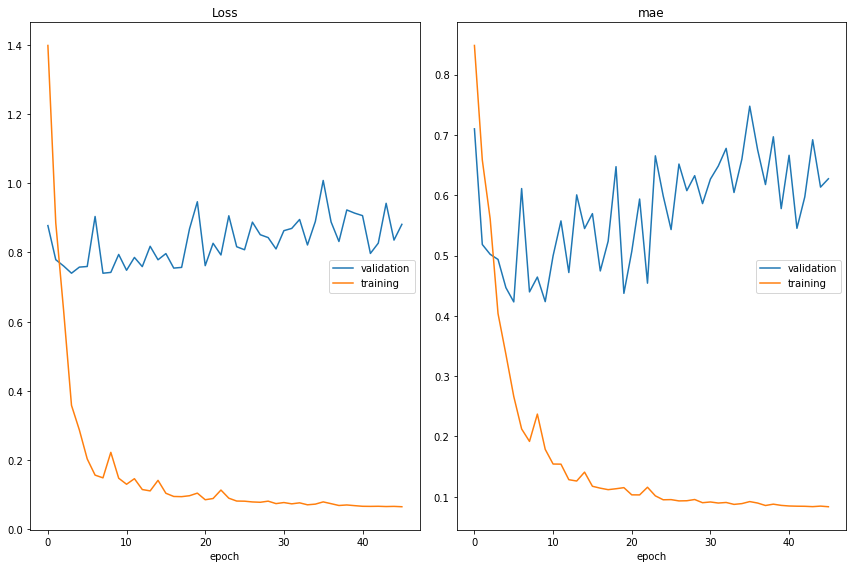

Loss
	validation       	 (min:    0.740, max:    1.008, cur:    0.881)
	training         	 (min:    0.065, max:    1.398, cur:    0.065)
mae
	validation       	 (min:    0.423, max:    0.748, cur:    0.627)
	training         	 (min:    0.084, max:    0.848, cur:    0.084)
Epoch 47/100
 39232/125114 [========>.....................] - ETA: 1:07 - loss: 0.0638 - mae: 0.0825

KeyboardInterrupt: 

In [24]:
n_item_features = 4961
n_user_features = 9
embedding_size = 256
model = hybrid_recommender_v2(n_item_features, n_user_features, embedding_size)

best = ModelCheckpoint('./models/recommender.h5',
                        monitor='val_loss',
                        verbose=0,
                        save_best_only=True,
                        mode='auto')

history = model.fit([train.reviewerID, train.item_id, train_item_metadata, train_user_metadata, np.vstack(train.image_features_encoded)]
                    , train.rating
                    , batch_size=32, epochs=100
                    , validation_split=0.2
                    , validation_data=([test.reviewerID, test.item_id, test_item_metadata, test_user_metadata, np.vstack(test.image_features_encoded)], test.rating)
                    , callbacks = [PlotLossesKeras(), best]
                    , shuffle=True)

### Make Predictions and Recommandations

In [25]:
from sklearn.metrics import mean_squared_error

In [27]:
# load trained model
model = load_model('./models/recommender.h5') # model generated from v2 architecture

In [28]:
# get predictions
preds = model.predict([test.reviewerID, test.item_id, test_item_metadata, test_user_metadata, np.vstack(test.image_features_encoded)])
preds = np.array([x[0] for x in preds])

In [30]:
mse = mean_squared_error(test['rating'].values, preds)
mse

0.7400929887620822